### Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm   # ref: https://github.com/tqdm/tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


### Loading human detection training data

In [3]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [4]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

### Video data loading

In [5]:
# Save corresponding clips 
frame_buffer_n = 3   # how many frames for 3d conv (+- n)
path = 'videos/'
frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        frame_buffer = []
        for iBuffer in range(-frame_buffer_n, frame_buffer_n+1):
            cap.set(1, int(iFrame)+iBuffer)
            ret, frame = cap.read()
            if ret:
                frame_buffer.append(frame)
        frames[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

100%|██████████| 10/10 [05:13<00:00, 31.39s/it]


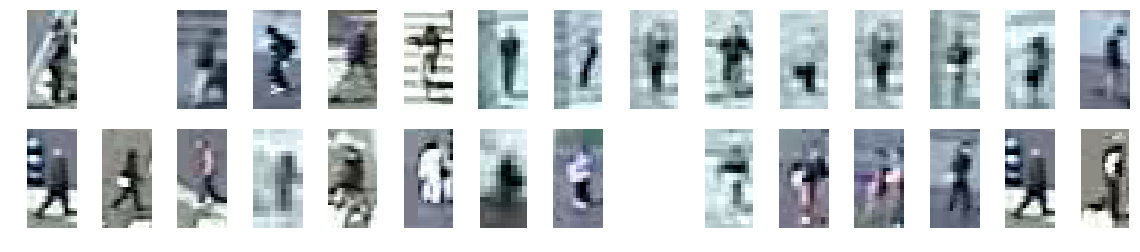

In [6]:
# Random sanity check
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][frame_buffer_n, y:y+h, x:x+w, :]) # when the pedestrian is at center
    except:
        continue

### Training data with (3d; stack of) images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

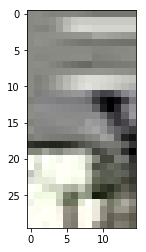

In [238]:
# Generating train data. All images are cropped to (30, 15).
# True data
X_sample = torch.zeros(nData,3,2*frame_buffer_n+1,30,15)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-15)/2)
                y -= int((h-30)/2)
                if i == 100:
                    imshow(frames[iClip][iFrame][frame_buffer_n, y:y+30, x:x+15,:])
                data = frames[iClip][iFrame][:, y:y+30, x:x+15, :].to(dtype=torch.float32)
                X_sample[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

100%|██████████| 1569/1569 [00:34<00:00, 46.10it/s]


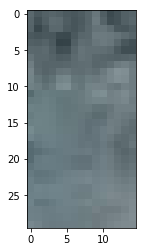

In [239]:
# False data are randomly sampled from images.
n = X_sample.shape[0]
for i in tqdm(range(1 * n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        if i == 100:
            imshow(frames[iClip][iFrame][frame_buffer_n, y:y+30, x:x+15,:])
        data = frames[iClip][iFrame][:, y:y+30, x:x+15,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(3,0,1,2),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

In [240]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [241]:
#X_train -= torch.mean(X_train, dim=0)

In [242]:
X_train.shape

torch.Size([2510, 3, 7, 30, 15])

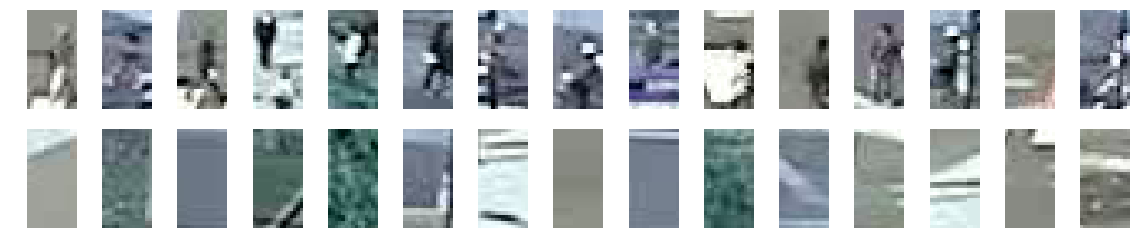

In [243]:
fig = plt.figure(figsize=(20,4))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n][:, frame_buffer_n, :, :].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n][:, frame_buffer_n, :, :].permute(1,2,0).to(dtype=torch.uint8))

In [244]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            #print(preds)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        
def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    for e in tqdm(range(epochs)):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(X_val, y_val, model)
                print()

In [245]:
#model = nn.Sequential(
#    nn.Conv2d(3, 16, 3, padding=1, stride=1),
#    Flatten(),
#    nn.Linear(16*15*30, 20),
#    nn.Linear(20, 2),
#)
#optimizer = optim.Adam(model.parameters(), lr=2.e-4, betas=(0.9, 0.999))

In [252]:
# Train CNN
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1, stride=1),
    #nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv3d(16, 16, 3, padding=1, stride=1),
    #nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv3d(16, 16, 3, padding=1, stride=1),
    #nn.BatchNorm2d(16),
    nn.ReLU(),
    #nn.Conv2d(16, 16, 3, padding=1, stride=1),
    #nn.BatchNorm2d(16),
    #nn.ReLU(),
    #nn.Conv2d(16, 16, 3, padding=1, stride=1),
    #nn.BatchNorm2d(16),
    #nn.ReLU(),
    Flatten(),
    nn.Linear(16*7*30*15, 20),
    #nn.Linear(20, 20)
    nn.ReLU(),
    nn.Linear(20, 2),
)
optimizer = optim.Adam(model.parameters(), lr=1.e-5, betas=(0.9, 0.999))

In [253]:
train_model(X_train, y_train, model, optimizer, epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Iteration 100, loss = 1.1617
Got 342 / 628 correct (54.46)

Iteration 200, loss = 3.0114
Got 325 / 628 correct (51.75)

Iteration 300, loss = 0.6303
Got 467 / 628 correct (74.36)

Iteration 400, loss = 0.5745
Got 437 / 628 correct (69.59)

Iteration 500, loss = 0.5172
Got 445 / 628 correct (70.86)

Iteration 600, loss = 0.5576
Got 420 / 628 correct (66.88)

Iteration 700, loss = 0.3931
Got 445 / 628 correct (70.86)

Iteration 800, loss = 2.3533
Got 389 / 628 correct (61.94)

Iteration 900, loss = 0.1038
Got 450 / 628 correct (71.66)

Iteration 1000, loss = 0.6578
Got 502 / 628 correct (79.94)

Iteration 1100, loss = 0.2253
Got 500 / 628 correct (79.62)

Iteration 1200, loss = 1.0551
Got 438 / 628 correct (69.75)



 50%|█████     | 1/2 [00:15<00:15, 15.84s/it]

Iteration 1300, loss = 0.9041
Got 483 / 628 correct (76.91)

Iteration 1400, loss = 0.4021
Got 519 / 628 correct (82.64)

Iteration 1500, loss = 0.0878
Got 508 / 628 correct (80.89)

Iteration 1600, loss = 2.0124
Got 504 / 628 correct (80.25)

Iteration 1700, loss = 0.4389
Got 542 / 628 correct (86.31)

Iteration 1800, loss = 0.2404
Got 538 / 628 correct (85.67)

Iteration 1900, loss = 0.0826
Got 542 / 628 correct (86.31)

Iteration 2000, loss = 0.0271
Got 541 / 628 correct (86.15)

Iteration 2100, loss = 0.1589
Got 495 / 628 correct (78.82)

Iteration 2200, loss = 0.5775
Got 532 / 628 correct (84.71)

Iteration 2300, loss = 0.1408
Got 539 / 628 correct (85.83)

Iteration 2400, loss = 0.3215
Got 540 / 628 correct (85.99)

Iteration 2500, loss = 0.0396


100%|██████████| 2/2 [00:32<00:00, 16.14s/it]

Got 536 / 628 correct (85.35)



In [254]:
for x in range(10):
    try:
        print(list(model.parameters())[x].shape)
    except:
        continue

torch.Size([16, 3, 3, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3, 3])
torch.Size([16])
torch.Size([20, 50400])
torch.Size([20])
torch.Size([2, 20])
torch.Size([2])


In [255]:
torch.cuda.empty_cache()

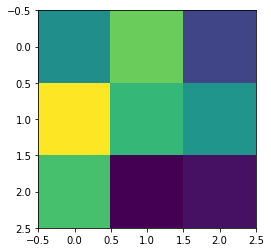

In [256]:
imshow(np.mean(list(model.parameters())[0][9].cpu().detach().numpy(), axis=0)[2])

In [208]:
list(model.parameters())[1][:].cpu().detach().numpy()

array([ 0.01545865, -0.10459326,  0.03304813, -0.09163815,  0.09505467,
        0.02077995,  0.00435067, -0.09561329, -0.11218765,  0.07280398,
       -0.02793769, -0.01338278,  0.09625522,  0.00337967, -0.0181768 ,
        0.04140214, -0.07074186, -0.0854966 ,  0.06597363,  0.08840209],
      dtype=float32)

In [165]:
frames['001']['0201'].permute(3, 0, 1, 2).unsqueeze(0).shape,
frames['001']['0401'].permute(3, 0, 1, 2).unsqueeze(0).shape

torch.Size([1, 3, 7, 480, 720])

In [167]:
X_train.shape

torch.Size([2510, 3, 7, 30, 15])

In [257]:
inputs = torch.from_numpy(np.vstack((frames['001']['0201'].permute(3, 0, 1, 2).unsqueeze(0), frames['001']['0401'].permute(3, 0, 1, 2).unsqueeze(0)))).to(dtype=torch.float32)
filters = torch.from_numpy(list(model.parameters())[0].cpu().detach().numpy()).to(dtype=torch.float32)
z = F.conv3d(inputs, filters, padding=1, stride=1)

In [259]:
z.shape

torch.Size([2, 16, 7, 480, 720])

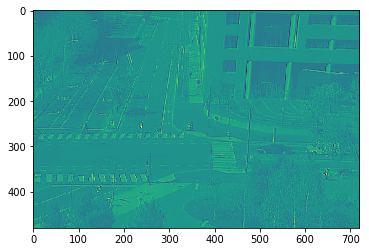

In [314]:
# first layer detects pedestrian??
# This shows highest score in space after 3d convolution with first layer
imshow(z[1, 15, 1, :, :].numpy(), vmax=100)

In [122]:
list(model.parameters())[1]

Parameter containing:
tensor([-0.0148, -0.0465,  0.0178,  0.0136,  0.0676, -0.0198,  0.0156,
        -0.0904,  0.0857, -0.0899, -0.0953,  0.0327, -0.0678,  0.0827,
        -0.0450,  0.1092], device='cuda:0')

In [141]:
z.numpy()[0, :, 3, :, :].T.shape

(720, 480, 16)

In [137]:
list(model.parameters())[1].cpu().detach().numpy().shape

(16,)

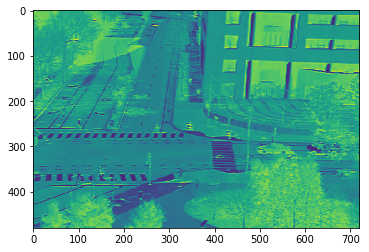

In [331]:
imshow(np.dot(z.numpy()[0, :, 1, :, :].T, list(model.parameters())[1].cpu().detach().numpy()).T)

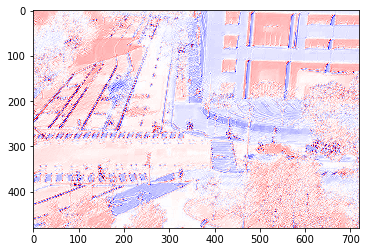